Homework 5

Question 12 (b)

In [1]:
import numpy as np
from scipy.stats import norm, poisson

In [2]:
lambda_0 = 1
n = 20
alpha = 0.05
repetition = 10000

simulate $X_{1},X_{2},...X_{n}$~ $Poisson(\lambda_{0})$ and perform the Wald test

In [3]:
X = poisson.rvs(lambda_0, size =n)
z = norm.ppf(1- alpha/2)
T = (abs(np.mean(X)-lambda_0))*(np.sqrt(n*np.mean(X)))
if T > z:
    print("reject the null hypothesis")
else:
    print("not reject the null hypothesis")
        

not reject the null hypothesis


In [4]:
reject_count = 0
z = norm.ppf(1- alpha/2)
for i in range(repetition):
    X = poisson.rvs(lambda_0, size = n)
    T = ((np.mean(X)-lambda_0))**2*n*np.mean(X)
    if T > z**2:
         reject_count +=1
ratio = reject_count / repetition
print("The probability that we reject the null hypothesis: ", ratio)

The probability that we reject the null hypothesis:  0.0496


type one error rate is very close to 0.05

Additional problem

In [37]:
import numpy as np
from tqdm import tqdm
from scipy import stats
import autograd.numpy as np
from autograd import grad, jacobian, hessian 
import matplotlib.pyplot as plt
from math import e

In [38]:
n = 1000
m = 2
mu1 = 2
mu2 = -2
sigma1 = 1
sigma2 = 1
p1 = 1/4
p2 = 3/4
class_prob = [p1, p2]
mus = [mu1, mu2]
sigmas = [sigma1, sigma2]
theta = [mu1, mu2, sigma1, sigma2, p1, p2]

generate  $i.i.d   X_{1}, X_{2}, ...X_{n}$~$F$.We moedel the data as being generated by a Gaussian mixture model $f_{\theta} $ with $m=2$ mixture components and parameters $\mu_{1} = 2, \mu_{2} = -2, \sigma_{1}=1, \sigma_{2}=1,p_{1}= \frac{1}{4}, p_{2} = \frac{3}{4}$

In [39]:
U = np.random.uniform(0,1,n)
dataset = np.zeros((n, 2))
for i in range(n):
    if U[i] < p1:
        dataset[i][0] = 1
        dataset[i][1] = mu1 + np.random.randn()
    else:
        dataset[i][0] = 2
        dataset[i][1] = mu2 + np.random.randn()
data = dataset[:, 1]

We want to minimize the following negative log-likelihood :

$L(\theta):= L(\mu, \alpha, \beta) := - \sum_{i=1}^{n}log[\frac{1}{\sum_{l=1}^{2}exp(\beta_{l})}\sum_{k=1}^{2}exp(\beta_{k})\phi(X_{i}; \mu_{k}, exp(\alpha_{k}))]$

$p_{k} = \frac{exp(\beta_{k})}{\sum_{l=1}^{2}exp(\beta_{l})}$

$\sigma_{k} = exp(\alpha_{k})$


In [40]:
def L0(mu1, mu2, alpha1, alpha2, beta1, beta2):
    sum = 0    
    for i in range(n):
        coef = 1/(np.exp(beta1) + np.exp(beta2))
        phi_sum1 = (1/(np.sqrt(2* np.pi)*np.exp(alpha1))) * np.exp((-(data[i]-mu1)**2)/(2* (np.exp(alpha1))**2))
        phi_sum2 = (1/(np.sqrt(2* np.pi)*np.exp(alpha2))) * np.exp((-(data[i]-mu2)**2)/(2* (np.exp(alpha2))**2))
        sum -= np.log(coef * (np.exp(beta1) *phi_sum1 + np.exp(beta2) * phi_sum2))
    return sum           
                     
def L(theta):
    return L0(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5])
                     

Find the minimum of L using the gradient descent

In [41]:
eps = 5e-5        # step size small enough to guarantee convergence
maxIter = 110   # maximum number of grad descent iterations
theta= np.array([2.0, -2.0,  0.0,  0.0,  3.0 ,3.0]) # initialization
gradL = grad(L)

In [42]:
def gradient_descent(maxIter, theta):

    for iter in tqdm(range(maxIter)):
        theta = theta - eps * gradL(theta) 
        L_gd_iterates[iter] = L(theta)
        mu1 = theta[0]
        mu2 = theta[1]
        sigma1 = np.exp(theta[2])
        sigma2 = np.exp(theta[3])
        p1 = np.exp(theta[4])/(np.exp(theta[4]) + np.exp(theta[5]))
        p2 = np.exp(theta[5])/(np.exp(theta[4]) + np.exp(theta[5]))
        mu_con_g [:,iter]= np.array([mu1, mu2])
        sigma_con_g [:,iter]= np.array([sigma1, sigma2])
        p_con_g [:, iter]= np.array([p1, p2])
    return theta, L_gd_iterates, mu_con_g, sigma_con_g, p_con_g



In [45]:
mu_con_g = np.zeros((2,maxIter))
sigma_con_g = np.zeros((2,maxIter))
p_con_g = np.zeros((2,maxIter))
L_gd_iterates = np.zeros(maxIter)
theta, L_gd_iterates, mu_con_g, sigma_con_g, p_con_g = gradient_descent(maxIter, theta)


100%|██████████| 110/110 [03:08<00:00,  1.71s/it]


In [46]:
print("After 110 iterations of gradient descent")
print("mu: ", mu_con_g[:,-1])
print("sigma: ", sigma_con_g[:,-1])
print("p: ", p_con_g[:,-1])

After 110 iterations of gradient descent
mu:  [ 1.84073624 -1.96614351]
sigma:  [1.10637772 0.97119702]
p:  [0.28333622 0.71666378]


EM-algorithm:

$T_{ki}^{j} = \frac{p_{k}^{j}\cdot \phi(x_{i};\mu_{k}^{j}, \sigma_{k}^{j})}{\sum_{l=1}^{m}p_{l}^{j}\cdot \phi(x_{i}; \mu_{l}^{j}, \sigma_{l}^{j})}$

update $p_{k}, \mu_{k}, \sigma_{k}$ using the formula

$p_{k}^{j+1}= \frac{1}{n} \cdot \sum_{i=1}^{n}T_{ki}^{j}$

$\mu_{k}^{j+1} = \frac{\sum_{i=1}^{n}T_{ki}^{j}x_{i}}{\sum_{i=1}^{n}T_{ki}^{j}}$

$\sigma_{k}^{j+1}= \sqrt{\frac{\sum_{i=1}{n}T_{ki}^{j}(x_{i}-\mu_{k}^{j+1})^{2}}{\sum_{i=1}^{n}T_{ki}^{j}}}$

In [51]:
def em(data, n_classes, num_iter):
    mus_con=np.zeros((n_classes, num_iter))
    sigma_con=np.zeros((n_classes, num_iter))
    p_con= np.zeros((n_classes, num_iter))
    n = data.shape[0]
    # initial guesses for the parameters
    mus = np.random.rand(n_classes)
    sigmas = np.random.rand(n_classes)
    class_probs = np.random.dirichlet(np.ones(n_classes)) # p1 and p2 are random but sum to 1
    
    for em_iter in tqdm(range(num_iter)):
        # E-step
        responsibilities = np.zeros((n, n_classes))
        for i in range(n):
            for c in range(n_classes):
                responsibilities[i][c]= class_probs[c] * (1/sigmas[c]* np.sqrt(2*np.pi))* np.exp(((data[i]-mus[c])**2)/(-2*sigmas[c]**2)) # numerator
        responsibilities = responsibilities / np.linalg.norm(responsibilities, axis= 1, ord = 1, keepdims = True) # T_{ki}^{j}
        class_responsibilities = np.sum(responsibilities, axis = 0) # sum of T_{ki}^{j}
        
        # M-step
        for c in range (n_classes):
            class_probs[c]= class_responsibilities[c]/n # update p_{k}^{j+1}
            mus[c] = np.sum(responsibilities[:, c] * data)/class_responsibilities[c] # update mu_{k}^{j+1}
            sigmas[c] = np.sqrt(np.sum(responsibilities[:, c] * (data-mus[c])**2)/class_responsibilities[c]) # update sigma_{k}^{j+1}
        mus_con[:,em_iter] = mus
        sigma_con[:, em_iter] = sigmas
        p_con [:,em_iter] = class_probs
    return class_probs, mus, sigmas, mus_con, sigma_con, p_con


In [52]:
n = 1000
class_probs = [1/4, 3/4] # p1 and p2
mus = [2, -2]
sigmas = [1, 1]
n_classes = 2
num_iter = 110

In [53]:
# generate data from mixture gaussian model
U = np.random.uniform(0,1,n)
dataset = np.zeros((n, 2))
for i in range(n):
    if U[i] < p1:
        dataset[i][0] = 1
        dataset[i][1] = mu1 + np.random.randn()
    else:
        dataset[i][0] = 2
        dataset[i][1] = mu2 + np.random.randn()

In [54]:
data = dataset[:, 1]
class_prob, mus, sigmas,  mus_con, sigma_con, p_con = em(data, n_classes, num_iter)
print("after 110 iterations")
print("class probability: ", class_prob)
print("mus: ", mus)
print("sigmas: ", sigmas)


100%|██████████| 110/110 [00:01<00:00, 57.53it/s]

after 110 iterations
class probability:  [0.73496932 0.26503068]
mus:  [-1.96625015  2.03515488]
sigmas:  [1.02299178 0.96659372]


Compare the convergence profile of both optimization approach

Text(0.5, 1.0, 'convergence of mu in gradiemt descent')

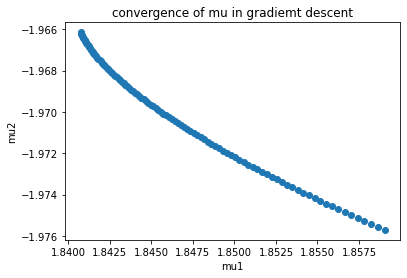

In [55]:
x_g = mu_con_g[0]
y_g = mu_con_g[1]
plt.scatter(x_g,y_g)
plt.xlabel("mu1")
plt.ylabel("mu2")
plt.title("convergence of mu in gradiemt descent")

Text(0.5, 1.0, 'convergence of mu in EM')

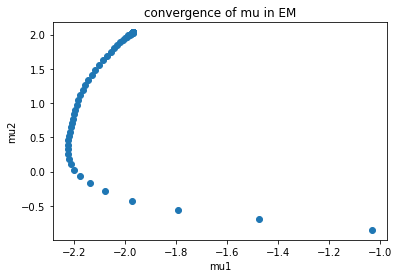

In [56]:
x = mus_con[0]
y = mus_con[1]
plt.scatter(x,y)
plt.xlabel("mu1")
plt.ylabel("mu2")
plt.title("convergence of mu in EM")

$\mu$ converges more efficiently in EM than in gradient descent

Text(0.5, 1.0, 'convergence of sigma in gradient descent')

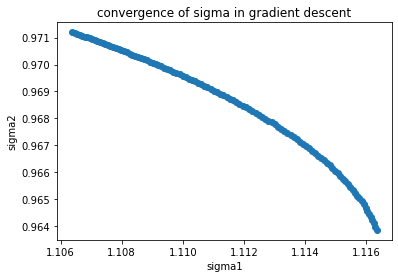

In [57]:
x_g2 = sigma_con_g[0]
y_g2 = sigma_con_g[1]
plt.scatter(x_g2,y_g2)
plt.xlabel("sigma1")
plt.ylabel("sigma2")
plt.title("convergence of sigma in gradient descent")

Text(0.5, 1.0, 'convergence of sigma in EM')

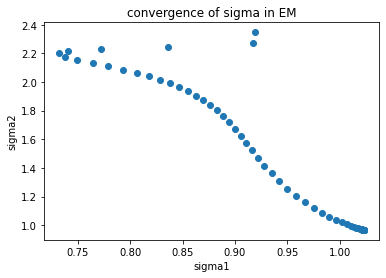

In [58]:
x2 = sigma_con[0]
y2 = sigma_con[1]
plt.scatter(x2,y2)
plt.xlabel("sigma1")
plt.ylabel("sigma2")
plt.title("convergence of sigma in EM")

$\sigma$ converges more efficiently in EM than in gradient descent

Text(0.5, 1.0, 'convergence of p in gradient descent')

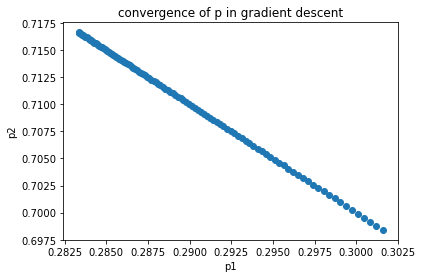

In [59]:
x_g3 = p_con_g[0]
y_g3 = p_con_g[1]
plt.scatter(x_g3,y_g3)
plt.xlabel("p1")
plt.ylabel("p2")
plt.title("convergence of p in gradient descent")

Text(0.5, 1.0, 'convergence of p in EM')

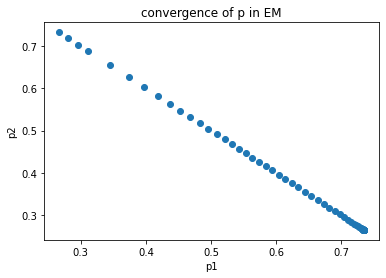

In [60]:
x3 = p_con[0]
y3 = p_con[1]
plt.scatter(x3,y3)
plt.xlabel("p1")
plt.ylabel("p2")
plt.title("convergence of p in EM")

$p$ converges more efficiently in EM than in gradient descent

Plot the PDF $f_{\hat{\theta}}$ produced by gradient descent

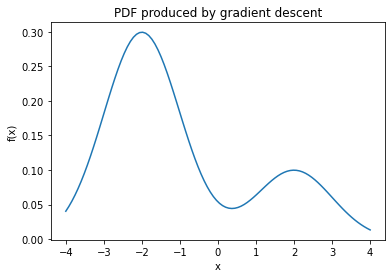

In [61]:
x = np.linspace(-4, 4, 100)
plt.plot(x, p1* stats.norm.pdf(x, mu1, sigma1)+p2* stats.norm.pdf(x, mu2, sigma2))
plt.title("PDF produced by gradient descent")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

plot the PDF of $f_{\hat{\theta}}$ produced by the EM algorithm

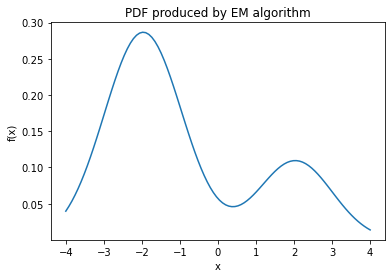

In [62]:
x = np.linspace(-4, 4, 100)
plt.plot(x, class_prob[0]* stats.norm.pdf(x, mus[0], sigmas[0])+class_prob[1]* stats.norm.pdf(x, mus[1], sigmas[1]))
plt.title("PDF produced by EM algorithm")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

(b) We are not changing the distribution from which the $X_{i}$ are sampled, but rather we are changing the model $f_{\hat{\theta}}$ for the data

100%|██████████| 110/110 [00:02<00:00, 40.60it/s]


m= 3


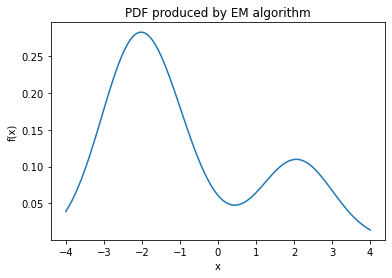

100%|██████████| 110/110 [00:04<00:00, 27.31it/s]


m= 4


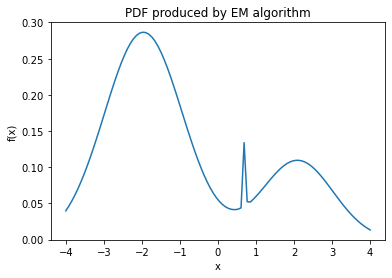

100%|██████████| 110/110 [00:04<00:00, 22.10it/s]


m= 5


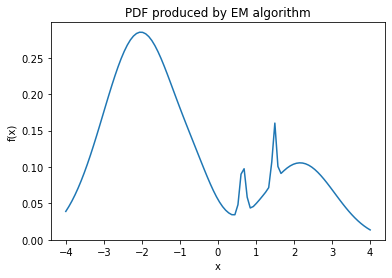

100%|██████████| 110/110 [00:06<00:00, 17.72it/s]


m= 6


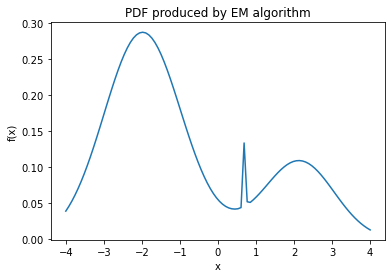

100%|██████████| 110/110 [00:19<00:00,  5.51it/s]


m= 20


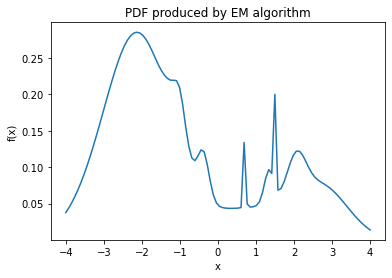

In [67]:
n = 50
m_list = [3, 4, 5, 6, 20]
data = dataset[:, 1]

for i in range(len(m_list)):
    f=0
    x = np.linspace(-4, 4, 100)
    ps, mus, sigmas, mus_con, sigma_con, p_con= em(data, m_list[i], num_iter)
    for j in range(m_list[i]):
        f += ps[j]* stats.norm.pdf(x, mus[j], sigmas[j])
    print("m=", m_list[i])
    plt.plot(x, f)
    plt.title("PDF produced by EM algorithm")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.show()
    

    
    



when m is very large, PDF have more bumps as we change our model